#                                                                                                                                   Project - 6  -page-2
#                                    Sales Forecasting Across Multiple Retail Stores

# Task 2 - Prediction of store sales


Step 2.1: Preprocessing

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import logging
# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()
logger.info("Logging is now working correctly.")

In [4]:
from google.colab import drive
drive.mount('/content/drive')
'/content/drive/MyDrive/'

Mounted at /content/drive


'/content/drive/MyDrive/'

In [5]:
train = pd.read_csv('/content/drive/MyDrive/eda_results.csv')

In [6]:
train.shape

(715912, 24)

In [7]:
#importing required libraries to perform further task
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [8]:
# Ensure Date is datetime
train['Date'] = pd.to_datetime(train['Date'], errors='coerce')
train = train.dropna(subset=['Date'])

# Date Feature
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.isocalendar().week.astype(int)
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['IsWeekend'] = (train['DayOfWeek'] >= 5).astype(int)

In [9]:
# Days to/from nearest state holiday
holidays = train[train['StateHoliday'] != '0']['Date'].unique()
train['DaysToHoliday'] = train['Date'].apply(lambda d: min([abs((d - h).days) for h in holidays]))

In [10]:
# Handle missing values(re handling missing values Promo's and distance column wise)
train["CompetitionDistance"].fillna(train["CompetitionDistance"].median(), inplace=True)
train["Promo2SinceWeek"].fillna(0, inplace=True)
train["Promo2SinceYear"].fillna(0, inplace=True)
train["PromoInterval"].fillna("None", inplace=True)

/tmp/ipython-input-10-488099951.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["CompetitionDistance"].fillna(train["CompetitionDistance"].median(), inplace=True)
/tmp/ipython-input-10-488099951.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [11]:
# Promo month flag
month_str = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
             7: "Jul", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}
train["CurrentMonth"] = train["Month"].map(month_str)
train["IsPromoMonth"] = train.apply(lambda row: 1 if row["CurrentMonth"] in row["PromoInterval"].split(",") else 0, axis=1)

In [12]:
# Label encode categorical variables
for col in ["StoreType", "Assortment", "StateHoliday"]:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

In [13]:
# Droping unused columns to train model.
train.drop(columns=["Date", "Customers", "PromoInterval", "CurrentMonth"], inplace=True)

In [14]:
# Define features and target
X = train.drop(columns=["Sales"])
y = train["Sales"]

In [15]:
# Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Scale numerical columns
scaler = StandardScaler()
for col in ["CompetitionDistance", "Promo2SinceWeek", "Promo2SinceYear"]:
    X_train[col] = scaler.fit_transform(X_train[[col]])
    X_valid[col] = scaler.transform(X_valid[[col]])
print(" Preprocessing completed", X_train.shape)

 Preprocessing completed (572729, 24)


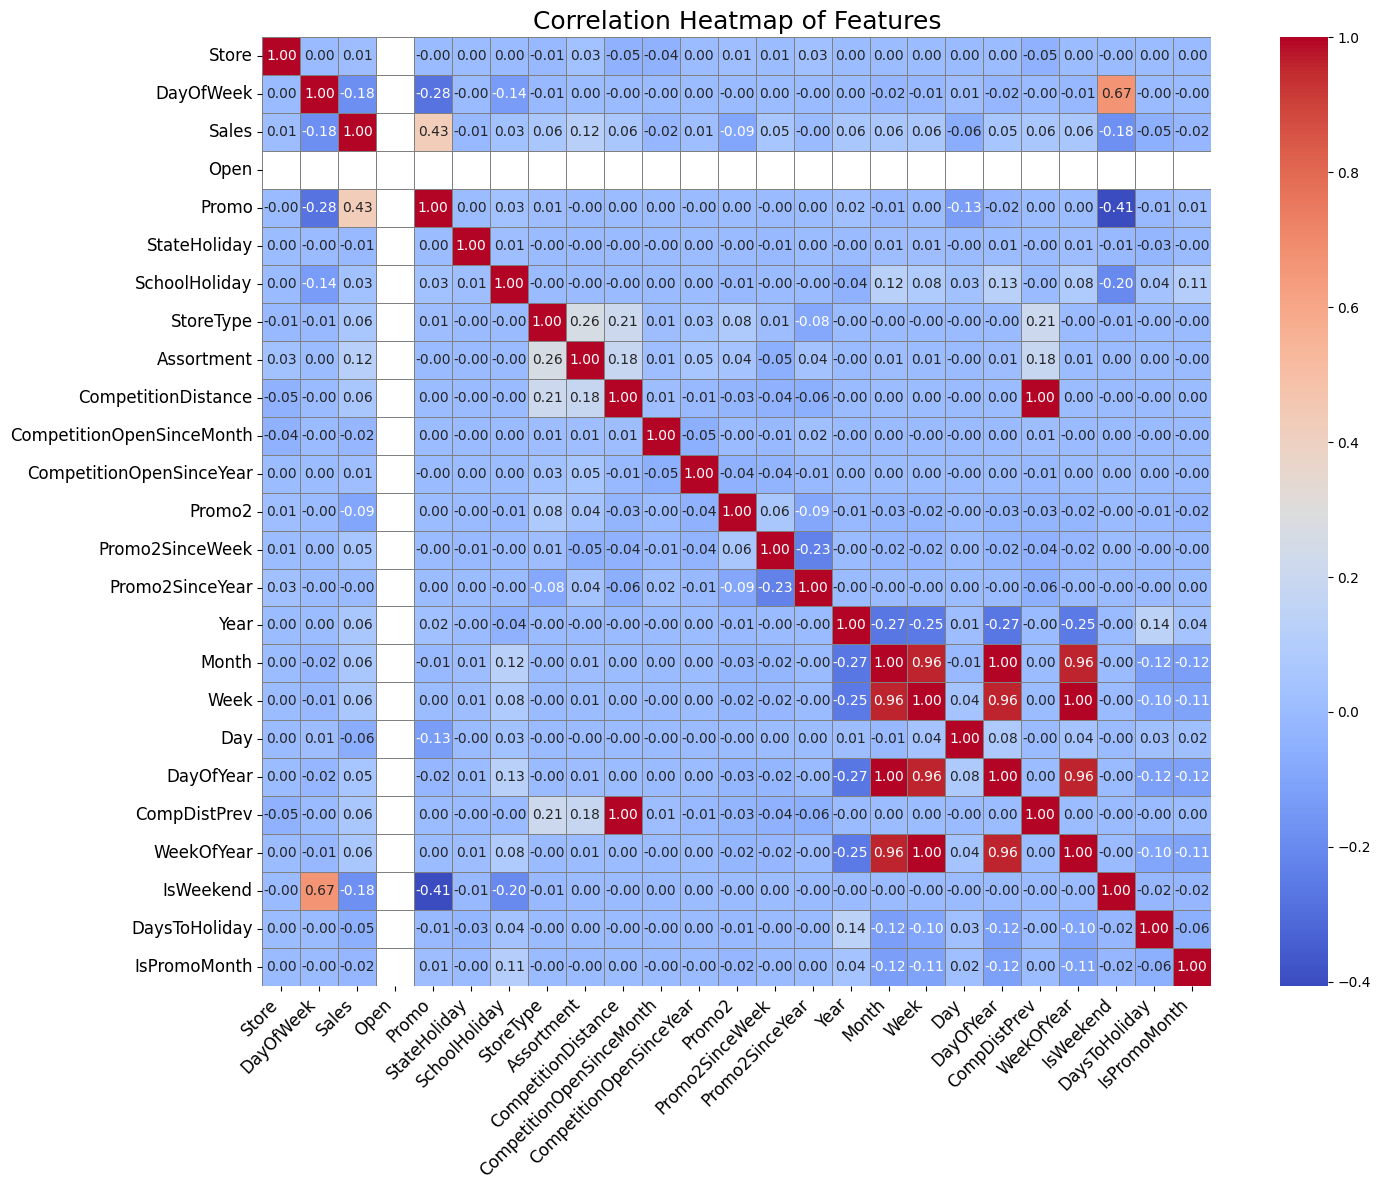

In [17]:
# Create the heatmap
plt.figure(figsize=(16, 12))
# Generate the correlation matrix
corr_matrix = train.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"size": 10}
)

# Add title and adjust layout
plt.title("Correlation Heatmap of Features", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

2.2 Building models with sklearn pipelines

In [18]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Week', 'Day',
       'DayOfYear', 'CompDistPrev', 'WeekOfYear', 'IsWeekend', 'DaysToHoliday',
       'IsPromoMonth'],
      dtype='object')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

target_column = 'Sales'

# Split features and target
X = train.drop(columns=["Sales"])
y = train["Sales"]
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train RandomForest model
model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f" Validation RMSE: {rmse:.2f}")

 Validation RMSE: 711.76


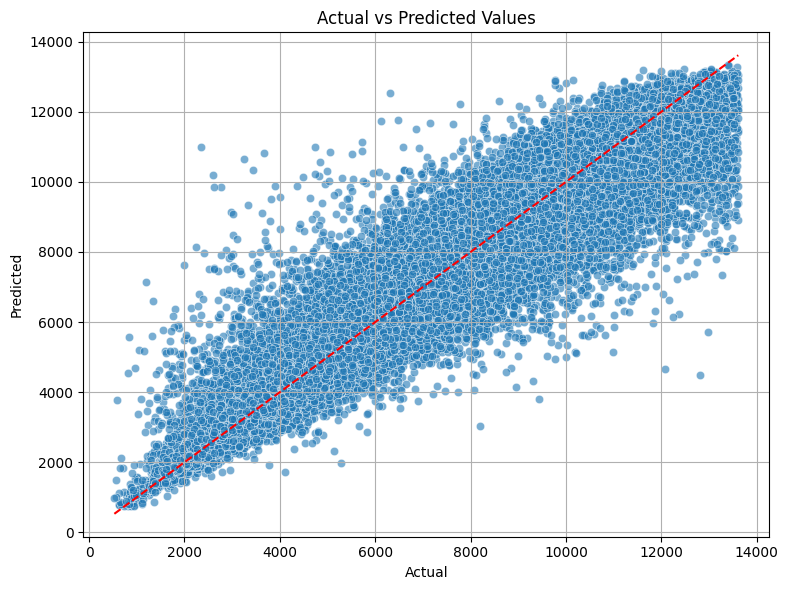

In [20]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


2.3: Loss Function Justification

In [21]:
# Custom loss: RMSLE (less punishing to large errors on high sales days)
rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_val))))
print(f" RMSLE: {rmsle:.3f} (preferred for skewed sales distribution)")

 RMSLE: 0.112 (preferred for skewed sales distribution)


2.4: Post Prediction Analysis

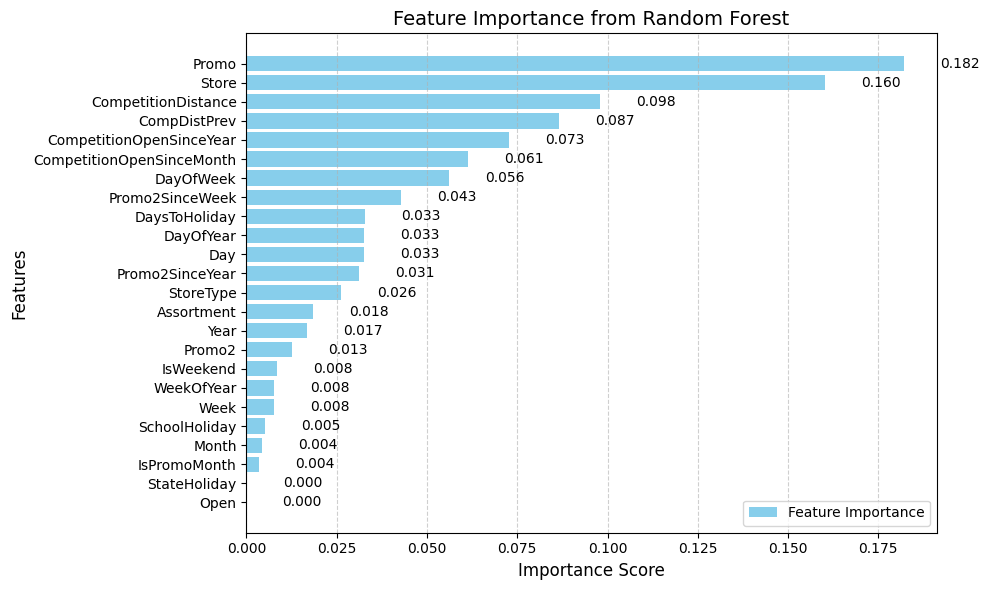

In [22]:
# Visualizing Feature importance
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values()

# Ploting
plt.figure(figsize=(10, 6))
bars = plt.barh(feat_importances.index, feat_importances.values, color='skyblue')
plt.title("Feature Importance from Random Forest", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adding legend
plt.legend(['Feature Importance'], loc='lower right')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

plt.tight_layout()
plt.show()

In [23]:
# Confidence Intervals (quick CI using std dev)
errors = np.abs(y_val - y_pred)
ci = np.percentile(errors, [5, 95])
print(f" Approx. 90% Confidence Interval: ±{int(ci[1])}")

 Approx. 90% Confidence Interval: ±1418


 2.5: Serialize Model

In [24]:
import joblib
from datetime import datetime

# Generate timestamp using datetime.now()
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
filename = f"model_{timestamp}.pkl"

# Save the model
joblib.dump(model, filename)
print(f" Model saved as: {filename}")


 Model saved as: model_2025-06-25-05-28-30.pkl


2.6 Building model with deep learning

In [25]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
 # importing required libraries for deep learning

In [26]:
train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Week', 'Day',
       'DayOfYear', 'CompDistPrev', 'WeekOfYear', 'IsWeekend', 'DaysToHoliday',
       'IsPromoMonth'],
      dtype='object')

In [27]:
# Isolate Time Series
# Filter for one store (e.g. Store 1)
train_store1 = train[train['Store'] == 1].sort_values('Year')

# Set Date as index and select Sales column
sales = train_store1[['Year', 'Sales']].set_index('Year')

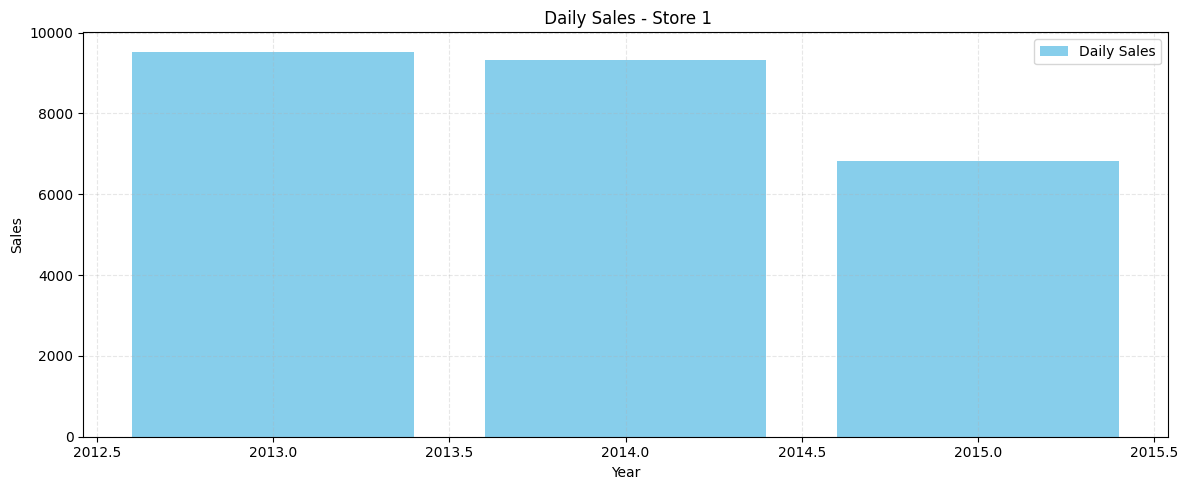

In [28]:
# Bar plot for daily sales
plt.figure(figsize=(12, 5))
plt.bar(sales.index, sales['Sales'], color='skyblue', label='Daily Sales')
plt.title(" Daily Sales - Store 1")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
#Stationarity Check & Differencing
# ADF stationarity test
result = adfuller(sales)
print('ADF Statistic: %.4f, p-value: %.4f' % (result[0], result[1]))

if result[1] > 0.05:
    dseries = sales.diff().dropna()
    print("Data differenced to remove non-stationarity.")
else:
    dseries = sales.copy()

ADF Statistic: -7.1813, p-value: 0.0000


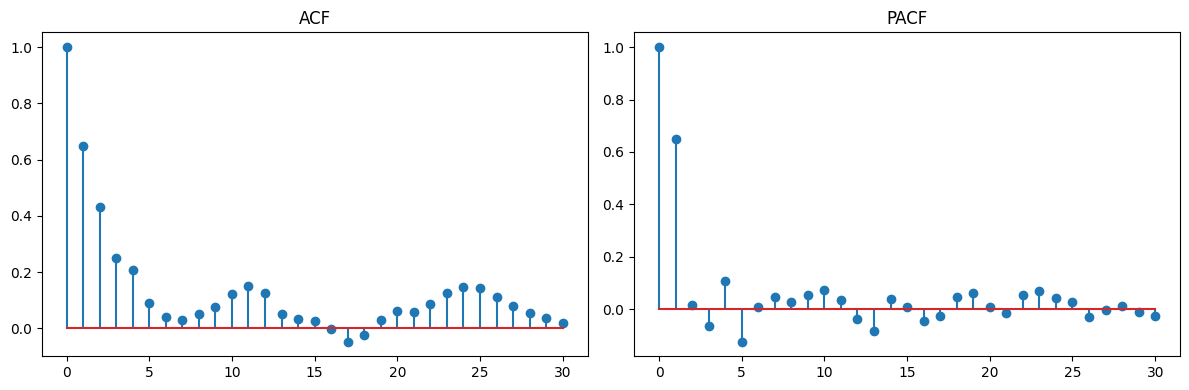

In [30]:
#ACF & PACF Plots
lags = 30
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].stem(acf(dseries, nlags=lags))
axes[0].set_title('ACF')
axes[1].stem(pacf(dseries, nlags=lags))
axes[1].set_title('PACF')
plt.tight_layout(); plt.show()

In [31]:
#Supervised Data via Sliding Window
def create_seq(series, window=14):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window = 14
series_values = dseries.values
X_seq, y_seq = create_seq(series_values, window)
print(f"Samples: {X_seq.shape}, Targets: {y_seq.shape}")

Samples: (767, 14, 1), Targets: (767, 1)


In [32]:
#Scale Data to (−1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_flat = X_seq.reshape(-1, 1)
X_scaled = scaler.fit_transform(X_flat).reshape(X_seq.shape)
y_scaled = scaler.transform(y_seq.reshape(-1,1)).ravel()

In [33]:
# Train/Val Split
val_split = int(len(X_scaled) * 0.8)
X_train, X_val = X_scaled[:val_split], X_scaled[val_split:]
y_train, y_val = y_scaled[:val_split], y_scaled[val_split:]

In [34]:
#Build & Train LSTM
model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    LSTM(25, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 - 5s - 271ms/step - loss: 0.0955 - val_loss: 0.0610
Epoch 2/50
20/20 - 1s - 71ms/step - loss: 0.0700 - val_loss: 0.0582
Epoch 3/50
20/20 - 1s - 31ms/step - loss: 0.0679 - val_loss: 0.0577
Epoch 4/50
20/20 - 1s - 30ms/step - loss: 0.0666 - val_loss: 0.0583
Epoch 5/50
20/20 - 1s - 32ms/step - loss: 0.0654 - val_loss: 0.0558
Epoch 6/50
20/20 - 1s - 32ms/step - loss: 0.0646 - val_loss: 0.0570
Epoch 7/50
20/20 - 1s - 29ms/step - loss: 0.0633 - val_loss: 0.0539
Epoch 8/50
20/20 - 1s - 32ms/step - loss: 0.0622 - val_loss: 0.0532
Epoch 9/50
20/20 - 1s - 31ms/step - loss: 0.0603 - val_loss: 0.0506
Epoch 10/50
20/20 - 1s - 31ms/step - loss: 0.0590 - val_loss: 0.0480
Epoch 11/50
20/20 - 1s - 32ms/step - loss: 0.0565 - val_loss: 0.0434
Epoch 12/50
20/20 - 1s - 30ms/step - loss: 0.0526 - val_loss: 0.0392
Epoch 13/50
20/20 - 0s - 19ms/step - loss: 0.0483 - val_loss: 0.0360
Epoch 14/50
20/20 - 0s - 17ms/step - loss: 0.0443 - val_loss: 0.0361
Epoch 15/50
20/20 - 1s - 33ms/step - loss:

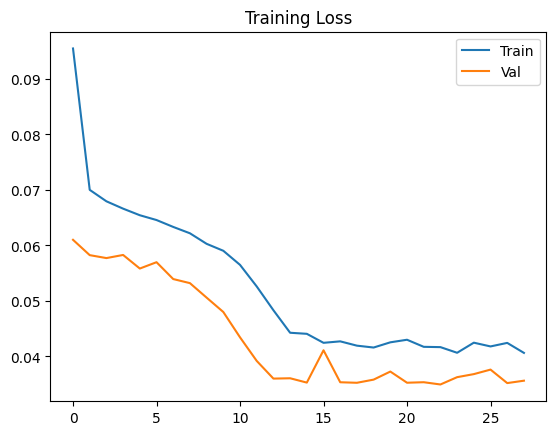

In [35]:
#Metrics & Plots
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Training Loss')
plt.legend()
plt.show()

In [36]:
# Evaluate performance
y_pred = model.predict(X_val).ravel()
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1)).ravel()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
rmse = np.sqrt(np.mean((y_pred_inv - y_val_inv)**2))
print(f" Validation RMSE: {rmse:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
 Validation RMSE: 669.71


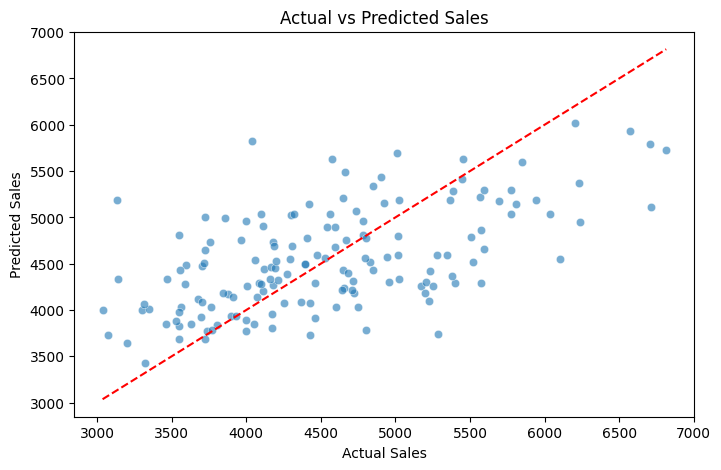

In [37]:
# Actual vs Pred
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_val_inv, y=y_pred_inv, alpha=0.6)
plt.plot([min(y_val_inv),max(y_val_inv)], [min(y_val_inv),max(y_val_inv)], 'r--')
plt.xlabel('Actual Sales'); plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

In [38]:
#Forecast Next Day Sales
# Use the last available sequence
last_sequence = X_scaled[-1].reshape(1, window, 1)
next_scaled_pred = model.predict(last_sequence)
next_sales_pred = scaler.inverse_transform(next_scaled_pred)[0][0]
print(f" Predicted next day's sales: {next_sales_pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 Predicted next day's sales: 4067.70


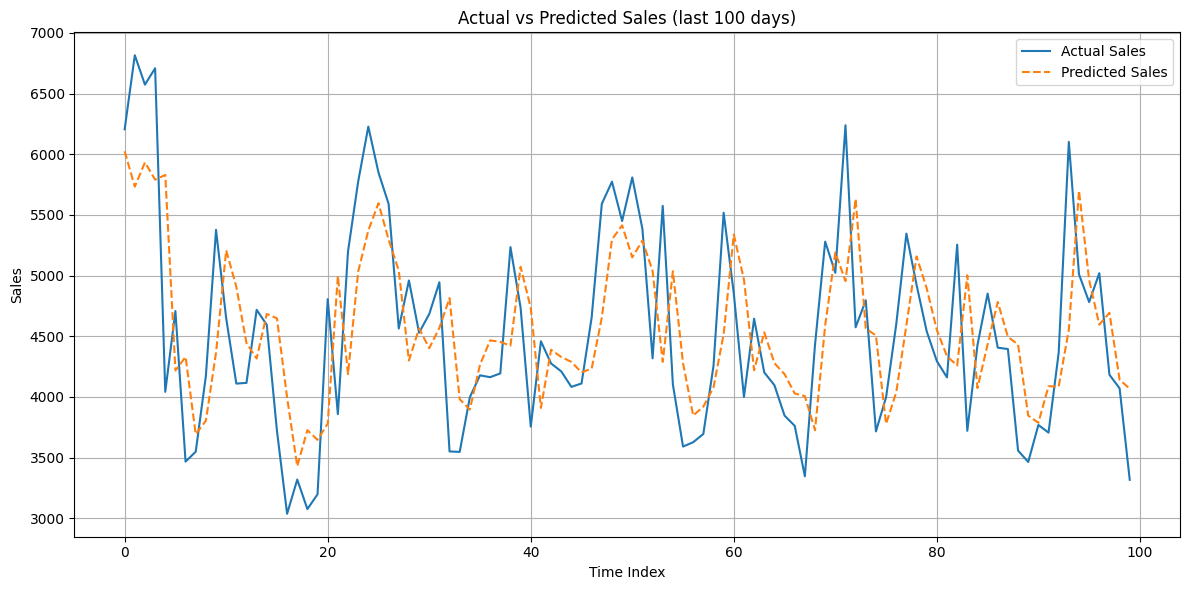

In [39]:
#Visualize Actual vs Predicted Over Time
# Compare the last N points
n_plot = 100
plt.figure(figsize=(12,6))
plt.plot(y_val_inv[-n_plot:], label="Actual Sales")
plt.plot(y_pred_inv[-n_plot:], label="Predicted Sales", linestyle='--')
plt.title("Actual vs Predicted Sales (last 100 days)")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
#Saving the LSTM Model
model.save('lstm_sales_model.keras')
print("LSTM model saved as 'lstm_sales_model.keras'")


LSTM model saved as 'lstm_sales_model.keras'


2.7: Serve with MLFlow (Lightweight Snippet)

In [41]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 14.9 MB/s eta 0:00:00


In [43]:
import pandas as pd
import mlflow
from mlflow.models.signature import infer_signature

# Sample input (update with real feature names & values)
input_example = pd.DataFrame([[1, 5, 1, 0, 0]], columns=['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday'])
signature = infer_signature(input_example, model.predict(input_example))

with mlflow.start_run():
    mlflow.log_metric("RMSE", rmse)

    mlflow.sklearn.log_model(
        model,
        name="random_forest_model",
        input_example=input_example,
        signature=signature
    )

    mlflow.log_artifact(filename)
    print("Model and artifact successfully logged to MLflow.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Model and artifact successfully logged to MLflow.


In [44]:
!mlflow models serve -m "mlruns/0/<RUN_ID>/artifacts/content/rf_model_2025-06-24-16-34-00.pkl" -p 5001

Traceback (most recent call last):
  File "/usr/local/bin/mlflow", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1442, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1363, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1830, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1830, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1226, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^

**Task 3 - Serving predictions on a web interface**

In [51]:
!pip install streamlit scikit-learn pandas matplotlib joblib --quiet
!pip install pyngrok --quiet  # To expose local Streamlit app

In [52]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler
import datetime

# Load the serialized model
model = joblib.load("rf_model_2025-06-24-16-34-00.pkl")

In [53]:
#Define Prediction Logic
def preprocess_input(data: pd.DataFrame) -> pd.DataFrame:
    data['Date'] = pd.to_datetime(data['Date'])
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Feature engineering: one-hot or label encoding as per training
    data = pd.get_dummies(data, columns=['StoreType', 'Assortment'], drop_first=True)

    # Assume these are the required model features:
    model_features = ['Store', 'DayOfWeek', 'IsPromo', 'IsHoliday', 'IsWeekend']
    data = data[model_features]  # Select only needed features
    return data

def predict_sales(data: pd.DataFrame):
    X = preprocess_input(data)
    X_scaled = scaler.transform(X)
    predictions = model.predict(X_scaled)
    return predictions

In [54]:
#Create Streamlit App
import streamlit as st
import matplotlib.pyplot as plt

st.title("Rossmann Sales Forecasting App")

# Upload CSV
uploaded_file = st.file_uploader("Upload CSV file", type="csv")

if uploaded_file:
    data = pd.read_csv(uploaded_file)
    st.write("Uploaded data preview:", data.head())

    if st.button("Predict Sales"):
        preds = predict_sales(data.copy())
        data['Predicted Sales'] = preds
        st.write("Prediction Results:", data)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(data['Date'], data['Predicted Sales'], label='Predicted Sales')
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.title("Sales Forecast")
        st.pyplot(plt)

        # Download
        csv = data.to_csv(index=False).encode()
        st.download_button("Download Predictions", csv, "predicted_sales.csv", "text/csv")

2025-06-25 05:40:15.747 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.093 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-25 05:40:16.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.114 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.117 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.119 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-25 05:40:16.122 Thread 'MainThread': mi

In [59]:
# Step 1: Set your ngrok authtoken
from pyngrok import conf
conf.get_default().auth_token = "2yzH9o5s0jHBr3jhfb6Hk1mepMM_2DLPbby5dw9RESWDcX2Dr"  # Replace with your token

# Step 2: Start the Streamlit server
!streamlit run app.py &>/content/log.txt &

# Step 3: Connect using correct ngrok method
from pyngrok import ngrok
url = ngrok.connect("http://localhost:8501")
print("Streamlit app is live at:", url)

Streamlit app is live at: NgrokTunnel: "https://56a6-34-23-54-99.ngrok-free.app" -> "http://localhost:8501"
